In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
import re
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import defaultdict, Counter
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

/Users/fafa/anaconda3/envs/python-crawler/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_variants = pd.read_csv('training/training_variants')
data_text = pd.read_csv('training/training_text', sep='\|\|', names=['ID', 'Text'], skiprows=1)

In [3]:
data_variants_t = pd.read_csv('testing/stage2_test_variants.csv')
data_text_t = pd.read_csv('testing/stage2_test_text.csv', sep='\|\|', names=['ID', 'Text'], skiprows=1)

In [4]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
Text    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [6]:
data_variants_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
ID           986 non-null int64
Gene         986 non-null object
Variation    986 non-null object
dtypes: int64(1), object(2)
memory usage: 23.2+ KB


In [7]:
data_text_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 2 columns):
ID      986 non-null int64
Text    986 non-null object
dtypes: int64(1), object(1)
memory usage: 15.5+ KB


In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
def data_text_preprocess(df_type, total_text, ind, col):
    if type(total_text) is not int:
        string = ""
        #除了a-zA-Z0-9之外的字符全部取代為空格
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        #將雙重空格變成單個空格
        total_text = re.sub('\s+', ' ', str(total_text))
        #將字母全部改成小寫
        total_text = total_text.lower()
        #移除虛詞
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        if df_type == 1:
            data_text[col][ind] = string
        else:
            data_text_t[col][ind] = string

In [10]:
for index, row in data_text.iterrows():
    if type(row['Text']) is str:
        data_text_preprocess(1, row['Text'], index, 'Text')

In [11]:
for index, row in data_text_t.iterrows():
    if type(row['Text']) is str:
        data_text_preprocess(2, row['Text'], index, 'Text')

In [12]:
result = pd.merge(data_variants, data_text, on='ID', how='left')

In [13]:
result_t = pd.merge(data_variants_t, data_text_t, on='ID', how='left')

In [14]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [15]:
result_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 985
Data columns (total 4 columns):
ID           986 non-null int64
Gene         986 non-null object
Variation    986 non-null object
Text         986 non-null object
dtypes: int64(1), object(3)
memory usage: 38.5+ KB


## 處理缺失值

In [16]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [17]:
result_t[result_t.isnull().any(axis=1)]

,ID,Gene,Variation,Text


In [18]:
result.loc[result['Text'].isnull(), 'Text'] = result['Gene'] + ' ' + result['Variation']

In [19]:
result_t.loc[result_t['Text'].isnull(), 'Text'] = result_t['Gene'] + ' ' + result_t['Variation']

## Training / Testing / Validation

In [20]:
y_true = result['Class']
result['Gene'] = result['Gene'].str.replace('\s+', '_')
result['Variation'] = result['Variation'].str.replace('\s+', '_')

In [21]:
result_t['Gene'] = result_t['Gene'].str.replace('\s+', '_')
result_t['Variation'] = result_t['Variation'].str.replace('\s+', '_')

In [23]:
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [24]:
print('Number of data points in train data: ', train_df.shape[0])
print('Number of data points in test data: ', test_df.shape[0])
print('Number of data points in cross validation data: ', cv_df.shape[0])

Number of data points in train data:  2124
Number of data points in test data:  665
Number of data points in cross validation data:  532


In [25]:
df_ = pd.DataFrame( {'Class' : train_df['Class'].value_counts().sort_index().index, 
                     'Count' : train_df['Class'].value_counts().sort_index().values},
                     columns=['Class','Count'])
df_['df'] = 'train'
df_['ratio'] = np.round(df_['Count'] / train_df.shape[0]*100, 3)

In [26]:
df_dist = pd.DataFrame()
df_dist = df_dist.append(df_)

In [27]:
df_ = pd.DataFrame( {'Class' : test_df['Class'].value_counts().sort_index().index, 
                     'Count' : test_df['Class'].value_counts().sort_index().values},
                     columns=['Class','Count'])
df_['df'] = 'test'
df_['ratio'] = np.round(df_['Count'] / test_df.shape[0]*100, 3)

In [28]:
df_dist = df_dist.append(df_)

In [29]:
df_ = pd.DataFrame( {'Class' : cv_df['Class'].value_counts().sort_index().index, 
                     'Count' : cv_df['Class'].value_counts().sort_index().values},
                     columns=['Class','Count'])
df_['df'] = 'cv'
df_['ratio'] = np.round(df_['Count'] / cv_df.shape[0]*100, 3)

In [30]:
df_dist = df_dist.append(df_)

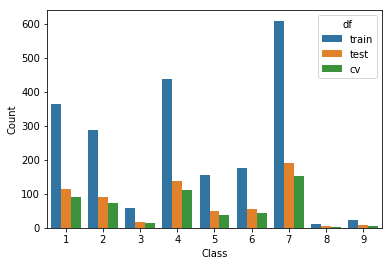

In [31]:
sns.barplot(x='Class', y='Count', data=df_dist, hue='df')

## 建立Random Model

In [32]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [33]:
cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = rand_probs / rand_probs.sum()
print('Log loss on Cross Validation Data using Random Model: ', log_loss(y_cv, cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model:  2.48932567967


In [34]:
test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = rand_probs / rand_probs.sum()
print('Log loss on Test Data using Random Model: ', log_loss(y_test, test_predicted_y))

Log loss on Test Data using Random Model:  2.49084620265


In [35]:
predict_y = np.argmax(test_predicted_y, axis=1)
predict_y += 1

### Confusion Matrix

In [36]:
cf_m = confusion_matrix(y_test, predict_y)

Text(69,0.5,'Original Class')

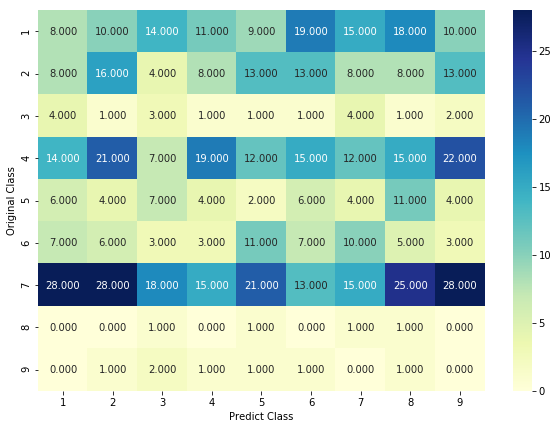

In [37]:
labels = range(1,10,1)
plt.figure(figsize=(10,7))
sns.heatmap(cf_m, cmap='YlGnBu', annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict Class')
plt.ylabel('Original Class')

### Precision Matrix

Text(69,0.5,'Original Class')

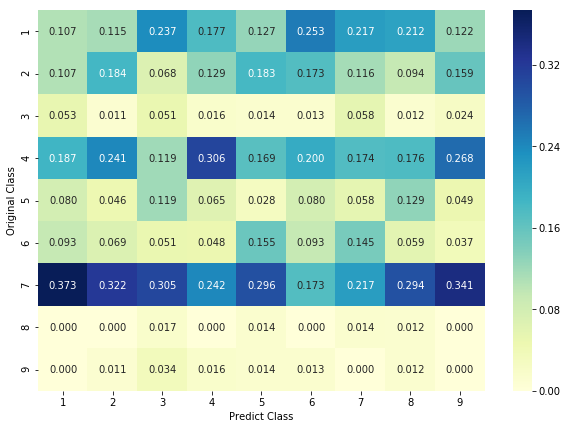

In [38]:
precision_m = cf_m / cf_m.sum(axis=0)
plt.figure(figsize=(10,7))
sns.heatmap(precision_m, cmap='YlGnBu', annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict Class')
plt.ylabel('Original Class')

### Recall Matrix

In [39]:
recall_m = cf_m.sum(axis=1)

Text(69,0.5,'Original Class')

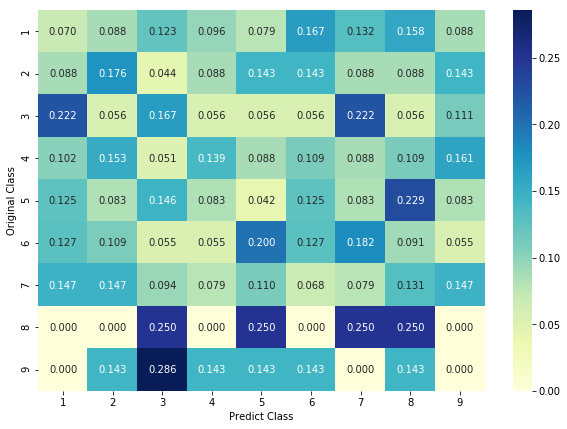

In [40]:
recall_m = (cf_m.T / cf_m.sum(axis=1)).T
plt.figure(figsize=(10,7))
sns.heatmap(recall_m, cmap='YlGnBu', annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict Class')
plt.ylabel('Original Class')

## 分析欄位

### Gene

In [41]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Gene: ',unique_genes.shape[0])
print(unique_genes.head())

Number of Unique Gene:  240
BRCA1    168
TP53     102
EGFR      85
BRCA2     84
PTEN      80
Name: Gene, dtype: int64


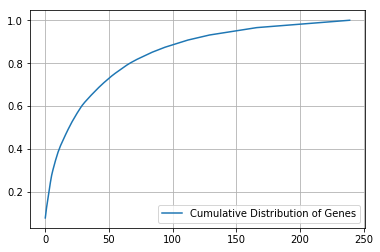

In [42]:
tot = sum(unique_genes.values)
rat = unique_genes.values / tot
cum = np.cumsum(rat)
plt.plot(cum, label='Cumulative Distribution of Genes')
plt.grid()
plt.legend()

#### One Hot Encoding

In [43]:
gene_vectorizer = CountVectorizer()
train_gene_onehotencoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_onehotencoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_onehotencoding = gene_vectorizer.transform(cv_df['Gene'])

In [44]:
result_t_gene_onehotencoding = gene_vectorizer.transform(result_t['Gene'].values.astype('U'))

#### 使用Gene來訓練Logistic Regression

In [45]:
alpha = [ 10 ** x for x in range(-5, 1)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_gene_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('alpha =', i, ', log loss =', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

alpha = 1e-05 , log loss = 1.37401601448
alpha = 0.0001 , log loss = 1.2199133238
alpha = 0.001 , log loss = 1.24696378594
alpha = 0.01 , log loss = 1.36138999635
alpha = 0.1 , log loss = 1.4616150443
alpha = 1 , log loss = 1.49382238604


Text(0,0.5,'Error')

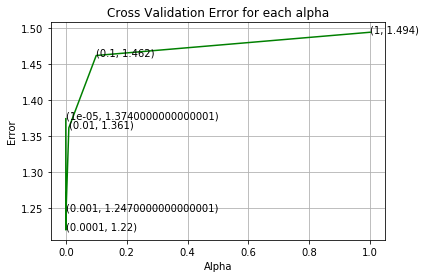

In [46]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('Alpha')
plt.ylabel('Error')

In [47]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the train log loss = ', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the cross validation log loss = ', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the test log loss = ', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Best alpha = 0.0001 , the train log loss =  1.02461139919
Best alpha = 0.0001 , the cross validation log loss =  1.2199133238
Best alpha = 0.0001 , the test log loss =  1.20142610157


### Variation

In [48]:
unique_variations = train_df['Variation'].value_counts()
print('Number of unique Variations: ', unique_variations.shape[0])
print(unique_variations.head(10))

Number of unique Variations:  1928
Truncating_Mutations    62
Deletion                48
Amplification           45
Fusions                 23
Overexpression           4
G12V                     3
Q61H                     3
Q61K                     2
Q61R                     2
E17K                     2
Name: Variation, dtype: int64


[ 0.02919021  0.05178908  0.07297552 ...,  0.99905838  0.99952919  1.        ]


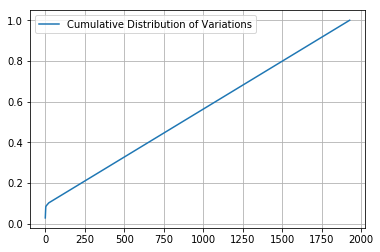

In [49]:
tot = sum(unique_variations.values)
rat = unique_variations.values / tot
cum = np.cumsum(rat)
print(cum)
plt.plot(cum, label='Cumulative Distribution of Variations')
plt.grid()
plt.legend()

#### One Hot Encoding

In [50]:
variation_vectorizer = CountVectorizer()
train_variation_onehotencoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_onehotencoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_onehotencoding = variation_vectorizer.transform(cv_df['Variation'])

In [51]:
result_t_variation_onehotencoding = variation_vectorizer.transform(result_t['Variation'].values.astype('U'))

#### 使用Variation來訓練Logistic Regression

In [52]:
alpha = [10 ** x for x in range(-5,1)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_onehotencoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('alpha = ', i, ', log loss = ', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

alpha =  1e-05 , log loss =  1.73166373538
alpha =  0.0001 , log loss =  1.72190609741
alpha =  0.001 , log loss =  1.72015584563
alpha =  0.01 , log loss =  1.71860092452
alpha =  0.1 , log loss =  1.72243332275
alpha =  1 , log loss =  1.72486808836


Text(0,0.5,'Error')

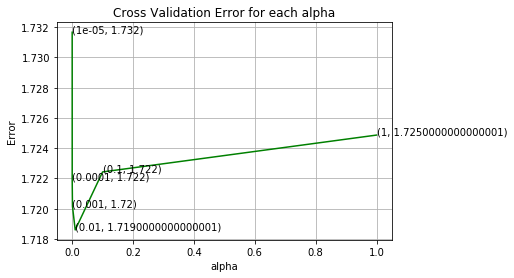

In [53]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('Error')

In [54]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the train log loss =', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the cross validation log loss =', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehotencoding)
print('Best alpha =', alpha[best_alpha], ', the test log loss =', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Best alpha = 0.01 , the train log loss = 1.39740893261
Best alpha = 0.01 , the cross validation log loss = 1.71860092452
Best alpha = 0.01 , the test log loss = 1.72543923527


### Text

In [55]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_onehotencoding = text_vectorizer.fit_transform(train_df['Text'])
train_text_features = text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_onehotencoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print('Total number of unique words in train data: ', len(train_text_features))

Total number of unique words in train data:  52926


#### One Hot Encoding

In [56]:
train_text_onehotencoding = normalize(train_text_onehotencoding, axis=0)

test_text_onehotencoding = text_vectorizer.transform(test_df['Text'])
test_text_onehotencoding = normalize(test_text_onehotencoding, axis=0)

cv_text_onehotencoding = text_vectorizer.transform(cv_df['Text'])
cv_text_onehotencoding = normalize(cv_text_onehotencoding, axis=0)

In [57]:
result_t_text_onehotencoding = text_vectorizer.transform(result_t['Text'].values.astype('U'))
result_t_text_onehotencoding = normalize(result_t_text_onehotencoding, axis=0)

#### 使用Text來訓練Logistic Regression

In [58]:
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_text_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('alpha = ', i, ', log loss = ', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

alpha =  1e-05 , log loss =  1.342242068
alpha =  0.0001 , log loss =  1.29986767193
alpha =  0.001 , log loss =  1.1690516
alpha =  0.01 , log loss =  1.26085871418
alpha =  0.1 , log loss =  1.44765764924
alpha =  1 , log loss =  1.6439055388


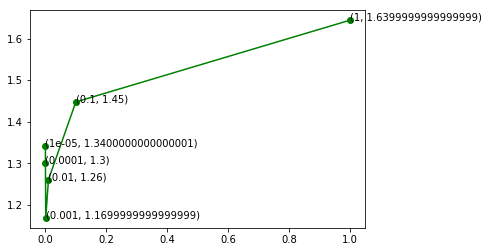

In [59]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i], np.round(txt,2)), (alpha[i], cv_log_error_array[i]))

In [60]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_text_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_text_onehotencoding)
print(' best alpha = ', alpha[best_alpha], ', the train log loss = ', log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_onehotencoding)
print(' best alpha = ', alpha[best_alpha], ', the cross validation log loss = ', log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_onehotencoding)
print(' best alpha = ', alpha[best_alpha], ', the test log loss = ', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

 best alpha =  0.001 , the train log loss =  0.739306039917
 best alpha =  0.001 , the cross validation log loss =  1.1690516
 best alpha =  0.001 , the test log loss =  1.2145851417


## Data Preparation for Machine Learning Models

In [61]:
#計算log loss
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [62]:
#由test_y和predict_y畫出 confusion matrix、precision matrix、recall matrix
def plot_confusion_matrix(test_y, predict_y):
    cf_m = confusion_matrix(test_y, predict_y)
    precision_m = cf_m/cf_m.sum(axis=0)
    recall_m = (cf_m.T/cf_m.sum(axis=1)).T
    labels = range(1,10,1)
    
    print('-'*20, 'Confusion Matrix', '-'*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(cf_m, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*20, 'Precision Matrix (Column Sum=1)', '-'*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(precision_m, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*20, 'Recall Matrix (Column Sum=0)', '-'*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(recall_m, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')  
    plt.show()
    
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    
    print('Log Loss: ', log_loss(test_y, sig_clf.predict_proba(test_x)))
    print('Number of miss-classified points: ', np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

## Combining all features 

In [63]:
train_gene_var_onehotencoding = hstack((train_gene_onehotencoding, train_variation_onehotencoding))
test_gene_var_onehotencoding = hstack((test_gene_onehotencoding, test_variation_onehotencoding))
cv_gene_var_onehotencoding = hstack((cv_gene_onehotencoding, cv_variation_onehotencoding))

train_x_onehotencoding = hstack((train_gene_var_onehotencoding, train_text_onehotencoding))
train_y = np.array(list(train_df['Class']))

test_x_onehotencoding = hstack((test_gene_var_onehotencoding, test_text_onehotencoding))
test_y = np.array(list(test_df['Class']))

cv_x_onehotencoding = hstack((cv_gene_var_onehotencoding, cv_text_onehotencoding))
cv_y = np.array(list(cv_df['Class']))

In [64]:
result_t_gene_var_onehotencoding = hstack((result_t_gene_onehotencoding, result_t_variation_onehotencoding))
result_t_x_onehotencoding = hstack((result_t_gene_var_onehotencoding, result_t_text_onehotencoding)).tocsr()

## Machine Learning

### Naive Bayes

In [65]:
alpha = [10 ** x for x in range(-5,4)]
cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotencoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotencoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print('alpha = ', i, ', log loss = ', log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))

alpha =  1e-05 , log loss =  1.30224534984
alpha =  0.0001 , log loss =  1.29399207853
alpha =  0.001 , log loss =  1.28951514017
alpha =  0.01 , log loss =  1.28594288382
alpha =  0.1 , log loss =  1.26812204543
alpha =  1 , log loss =  1.29535073034
alpha =  10 , log loss =  1.39420444337
alpha =  100 , log loss =  1.40364068749
alpha =  1000 , log loss =  1.3102270574


Text(0,0.5,'Error')

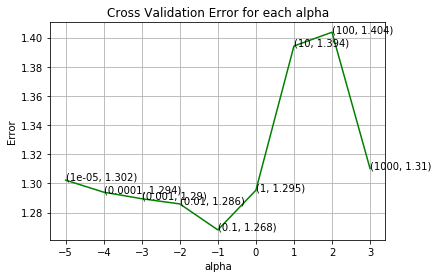

In [66]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):    
    ax.annotate((alpha[i], float(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('Error')

In [67]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotencoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', The train log loss = ', log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', The cross validation log loss = ', log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', The test log loss = ', log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

best alpha =  0.1 , The train log loss =  0.887120574731
best alpha =  0.1 , The cross validation log loss =  1.26812204543
best alpha =  0.1 , The test log loss =  1.25511039948


Log Loss =  1.26812204543
Number of Missclassified Point =  0.39285714285714285
-------------------- Confusion Matrix --------------------


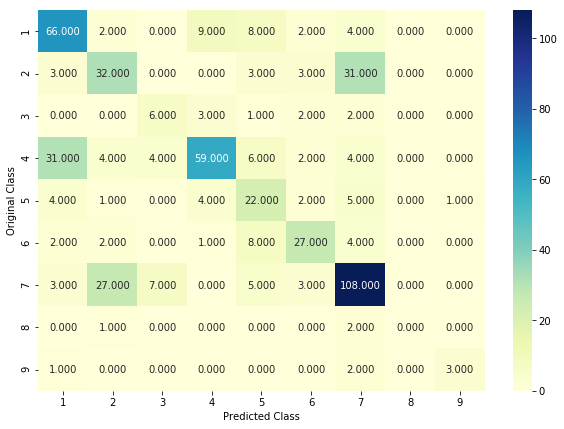

-------------------- Precision Matrix (Column Sum=1) --------------------


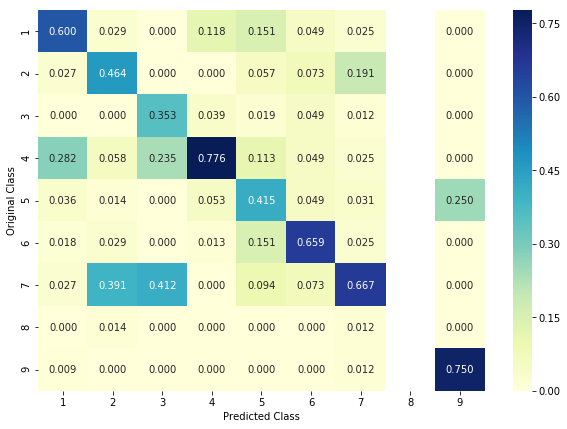

-------------------- Recall Matrix (Column Sum=0) --------------------


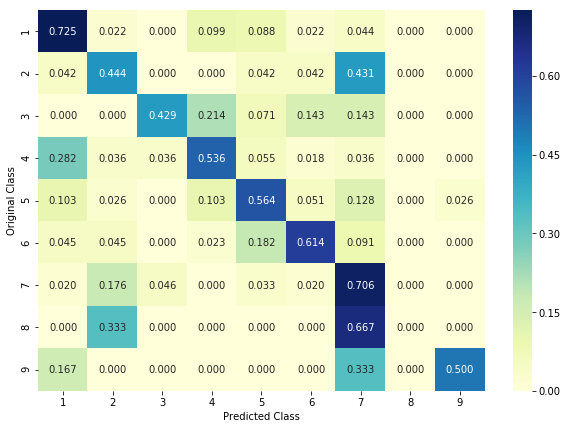

In [68]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotencoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
print('Log Loss = ', log_loss(cv_y, sig_clf_probs))
print('Number of Missclassified Point = ', np.count_nonzero((sig_clf.predict(cv_x_onehotencoding)-cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotencoding))

### Logistic Regression

In [69]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotencoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotencoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=sig_clf.classes_, eps=1e-15))
    print('alpha = ', i, ', Log Loss = ', log_loss(cv_y, sig_clf_probs))

alpha =  1e-06 , Log Loss =  1.35977594152
alpha =  1e-05 , Log Loss =  1.34947979394
alpha =  0.0001 , Log Loss =  1.28878612068
alpha =  0.001 , Log Loss =  1.09583639545
alpha =  0.01 , Log Loss =  1.13805758567
alpha =  0.1 , Log Loss =  1.41997009969
alpha =  1 , Log Loss =  1.6718121885
alpha =  10 , Log Loss =  1.70421468205
alpha =  100 , Log Loss =  1.70771442993


Text(0,0.5,'Error')

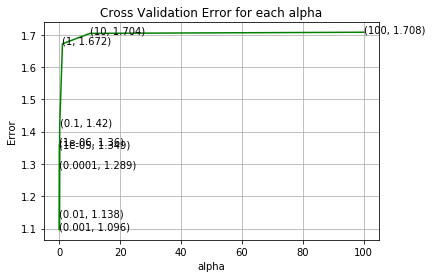

In [70]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], float(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('Error')

In [71]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotencoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', the train log loss = ', log_loss(train_y, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', the cross validation log loss = ', log_loss(cv_y, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('best alpha = ', alpha[best_alpha], ', the test log loss = ', log_loss(test_y, predict_y, labels=sig_clf.classes_, eps=1e-15))

best alpha =  0.001 , the train log loss =  0.599640276934
best alpha =  0.001 , the cross validation log loss =  1.09583639545
best alpha =  0.001 , the test log loss =  1.14174961969


Log Loss:  1.09583639545
Number of miss-classified points:  0.36278195488721804
-------------------- Confusion Matrix --------------------


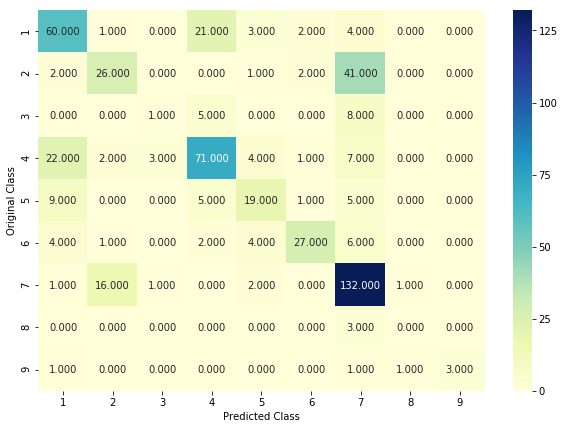

-------------------- Precision Matrix (Column Sum=1) --------------------


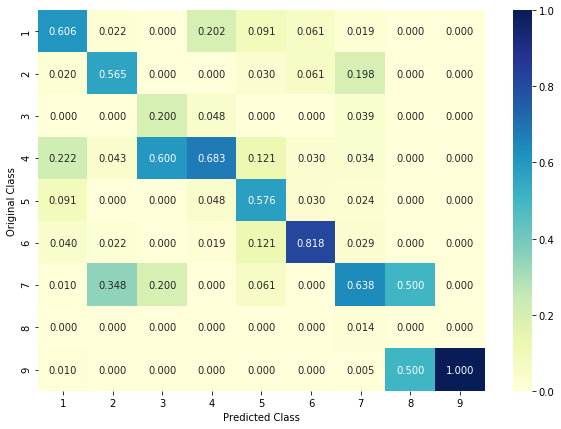

-------------------- Recall Matrix (Column Sum=0) --------------------


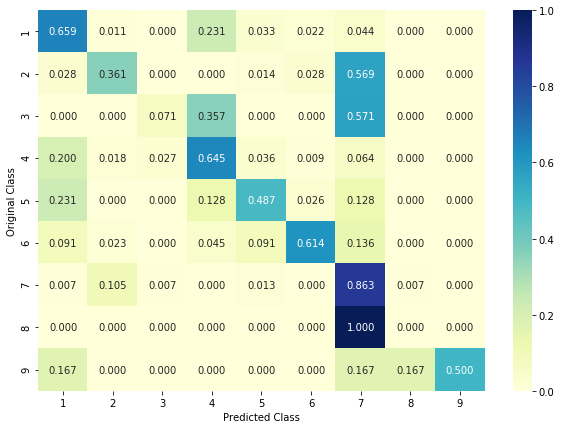

In [72]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotencoding, train_y, cv_x_onehotencoding, cv_y, clf)

### Linear SVM

In [73]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotencoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotencoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotencoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=sig_clf.classes_, eps=1e-15))
    print('C = ', i, ', Log Loss = ', log_loss(cv_y, sig_clf_probs))

C =  1e-05 , Log Loss =  1.31773636225
C =  0.0001 , Log Loss =  1.33240851848
C =  0.001 , Log Loss =  1.21284229221
C =  0.01 , Log Loss =  1.11062168482
C =  0.1 , Log Loss =  1.34398694101
C =  1 , Log Loss =  1.69272782037
C =  10 , Log Loss =  1.70828911903
C =  100 , Log Loss =  1.70835161658


Text(0,0.5,'Error')

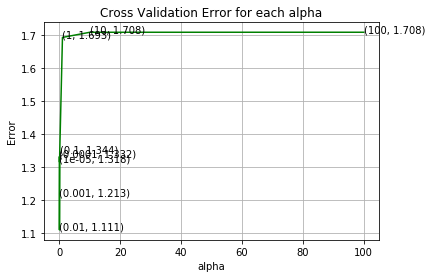

In [74]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], float(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('Error')

In [75]:
best_alpha = np.argmin(cv_log_error_array)
clf =SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotencoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotencoding)
print('best C = ', alpha[best_alpha], ', the train log loss = ', log_loss(train_y, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotencoding)
print('best C = ', alpha[best_alpha], ', the cross validation log loss = ', log_loss(cv_y, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
print('best C = ', alpha[best_alpha], ', the test log loss = ', log_loss(test_y, predict_y, labels=sig_clf.classes_, eps=1e-15))

best C =  0.01 , the train log loss =  0.725971904654
best C =  0.01 , the cross validation log loss =  1.11062168482
best C =  0.01 , the test log loss =  1.14999772211


Log Loss:  1.11062168482
Number of miss-classified points:  0.35714285714285715
-------------------- Confusion Matrix --------------------


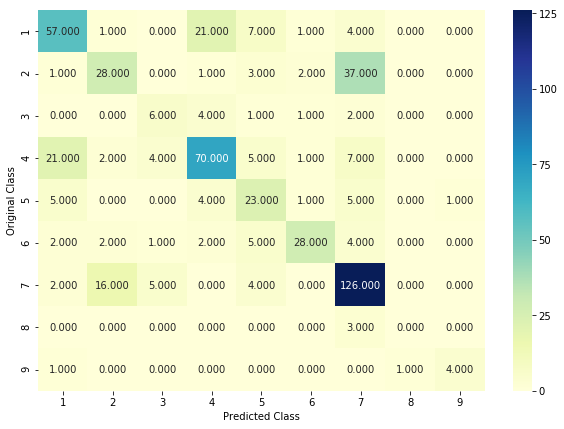

-------------------- Precision Matrix (Column Sum=1) --------------------


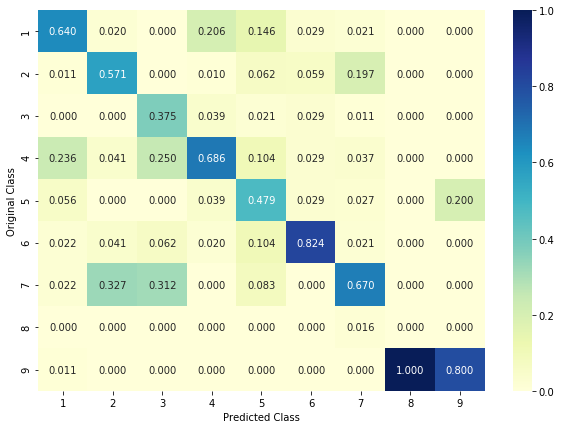

-------------------- Recall Matrix (Column Sum=0) --------------------


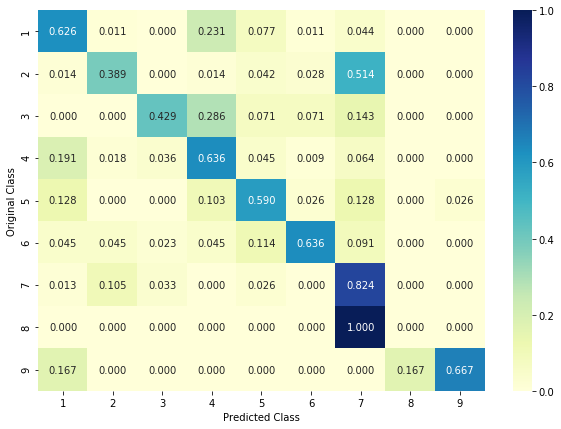

In [76]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotencoding, train_y, cv_x_onehotencoding, cv_y, clf)

### Stacking Classifier

In [77]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced',random_state=42)
clf1.fit(train_x_onehotencoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method='sigmoid')
sig_clf1.fit(train_x_onehotencoding, train_y)
print('Logistic Regression: Log Loss = %0.3f' %(log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotencoding))))

clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=42)
clf2.fit(train_x_onehotencoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method='sigmoid')
sig_clf2.fit(train_x_onehotencoding, train_y)
print('SVM: Log Loss = %0.3f' %(log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotencoding))))

clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_onehotencoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method='sigmoid')
sig_clf3.fit(train_x_onehotencoding, train_y)
print('Naive Bayes: Log Loss = %0.3f' %(log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotencoding))))

print('-'*50)

# alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
alpha = [10 ** x for x in range(-6, 3)]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotencoding, train_y)
    print('Stacking Classifier : alpha = %f , Log Loss = %0.3f' %(i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotencoding))))
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotencoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression: Log Loss = 1.096
SVM: Log Loss = 1.111
Naive Bayes: Log Loss = 1.295
--------------------------------------------------
Stacking Classifier : alpha = 0.000001 , Log Loss = 2.197
Stacking Classifier : alpha = 0.000010 , Log Loss = 2.195
Stacking Classifier : alpha = 0.000100 , Log Loss = 2.175
Stacking Classifier : alpha = 0.001000 , Log Loss = 2.009
Stacking Classifier : alpha = 0.010000 , Log Loss = 1.458
Stacking Classifier : alpha = 0.100000 , Log Loss = 1.148
Stacking Classifier : alpha = 1.000000 , Log Loss = 1.249
Stacking Classifier : alpha = 10.000000 , Log Loss = 1.486
Stacking Classifier : alpha = 100.000000 , Log Loss = 1.758


In [78]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotencoding, train_y)

StackingClassifier(average_probas=False,
          classifiers=[CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, rand...mator=MultinomialNB(alpha=1, class_prior=None, fit_prior=True),
            cv=3, method='sigmoid')],
          meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=True, verbose=0)

In [79]:
predict_class = sclf.predict(result_t_x_onehotencoding)

In [80]:
result_t['Predict_Class'] = predict_class

In [81]:
result_t.head()

,ID,Gene,Variation,Text,Predict_Class
0,1,CHEK2,H371Y,incidence breast cancer increasing china recen...,7
1,2,AXIN2,Truncating_Mutations,unselected series 310 colorectal carcinomas st...,1
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...,7
3,4,SUCLA2,G118R,regulated progression cell cycle requires sequ...,7
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerging tumor entity...,7


In [82]:
onehot = pd.get_dummies(result_t['Predict_Class'])

In [83]:
result_t = result_t.join(onehot)

In [84]:
result_t.head()

,ID,Gene,Variation,Text,Predict_Class,1,2,3,4,5,6,7,9
0,1,CHEK2,H371Y,incidence breast cancer increasing china recen...,7,0,0,0,0,0,0,1,0
1,2,AXIN2,Truncating_Mutations,unselected series 310 colorectal carcinomas st...,1,1,0,0,0,0,0,0,0
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...,7,0,0,0,0,0,0,1,0
3,4,SUCLA2,G118R,regulated progression cell cycle requires sequ...,7,0,0,0,0,0,0,1,0
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerging tumor entity...,7,0,0,0,0,0,0,1,0


In [85]:
result_t[8] = 0

In [87]:
submission_df = result_t[["ID",1,2,3,4,5,6,7,8,9]]

In [88]:
submission_df.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
submission_df.head(5)

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,1,0,0
1,2,1,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,1,0,0
3,4,0,0,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,1,0,0


In [89]:
submission_df.to_csv('submission.csv', index=False)